# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# imports
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

# Read Data

## Bus

In [3]:
route_str = 'B46'

In [4]:
route_file_path = f'/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/Segment Data - Processed/{route_str}_2021-10-18.csv'
route_df = pd.read_csv(route_file_path)
route_df['timestamp'] = pd.to_datetime(route_df['timestamp'])

#remove timzone info (looks wrong... FixedOffset of -240 would seem to imply that 4AM ridership > 7AM ridership (see `linear_regression_1` notebook chart: pred. vs. gt total passengers by time of day))
route_df['timestamp'] = route_df['timestamp'].apply(lambda dt: dt.replace(tzinfo=None))

In [5]:
route_df

,route,direction,trip_id,service_date,vehicle_id,timestamp,lat,lon,bearing,prior_stop_id,next_stop_id,next_stop_id_pos,next_stop_d_along_route,next_stop_est_sec,passenger_count
0,B46,1,MTA NYCT_FB_C1-Saturday-138700_B46_446,2021-07-31,MTA NYCT_7640,2021-08-01 00:00:56,40.646607,-73.929840,275.832550,MTA_308777,MTA_303690,35,8394.73,27.0,24.0
1,B46,0,MTA NYCT_FB_C1-Saturday-140800_B46_444,2021-07-31,MTA NYCT_7312,2021-08-01 00:01:00,40.679114,-73.929217,45.000000,MTA_308066,MTA_307092,33,7941.78,23.0,8.0
2,B46,0,MTA NYCT_FB_C1-Saturday-144000_B46_445,2021-07-31,MTA NYCT_7649,2021-08-01 00:01:55,40.611720,-73.924513,139.398710,MTA_300163,MTA_303590,3,676.65,99.0,0.0
3,B46,1,MTA NYCT_FB_C1-Saturday-138700_B46_446,2021-07-31,MTA NYCT_7640,2021-08-01 00:01:57,40.644874,-73.929649,276.391360,MTA_303690,MTA_303691,36,8609.88,25.0,24.0
4,B46,0,MTA NYCT_FB_C1-Saturday-140800_B46_444,2021-07-31,MTA NYCT_7312,2021-08-01 00:02:01,40.681071,-73.928692,101.481995,MTA_307092,MTA_303624,34,8215.23,21.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233094,B46,1,MTA NYCT_FB_D1-Weekday-SDon-059600_B46_426,2021-09-30,MTA NYCT_7305,2021-09-30 11:15:02,40.614654,-73.926421,276.371400,MTA_303703,MTA_303704,49,11902.75,33.0,0.0
233095,B46,1,MTA NYCT_FB_D1-Weekday-SDon-058800_B46_430,2021-09-30,MTA NYCT_7334,2021-09-30 11:16:37,40.611640,-73.924731,318.576320,MTA_307089,MTA_307636,51,12323.59,57.0,0.0
233096,B46,1,MTA NYCT_FB_D1-Weekday-SDon-059600_B46_426,2021-09-30,MTA NYCT_7305,2021-09-30 11:18:28,40.612019,-73.925143,316.847600,MTA_307089,MTA_307636,51,12323.59,25.0,0.0
233097,B46,1,MTA NYCT_FB_D1-Weekday-SDon-058800_B46_430,2021-09-30,MTA NYCT_7334,2021-09-30 11:19:05,40.608658,-73.921401,318.346830,MTA_307636,MTA_901093,52,12929.64,79.0,0.0


## Visual Crossing - JFK

In [6]:
station_str = 'JFK'

In [7]:
weather_file_path = f'/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Weather/vc_weather_data_{station_str}.csv'
weather_df = pd.read_csv(weather_file_path)
weather_df['Date time'] = pd.to_datetime(weather_df['Date time'])

In [8]:
weather_df

,Date time,Temperature,Precipitation,Wind Speed,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,2021-07-31 23:30:00,21.0,0.0,14.8,0.0,16.0,0.0,73.11,Clear
1,2021-07-31 23:35:00,20.0,0.0,14.8,0.0,16.0,0.0,77.76,Clear
2,2021-07-31 23:40:00,20.0,0.0,14.8,0.0,16.0,0.0,77.76,Clear
3,2021-07-31 23:45:00,21.0,0.0,14.8,0.0,16.0,0.0,73.11,Clear
4,2021-07-31 23:50:00,20.0,0.0,11.2,0.0,16.0,0.0,77.76,Clear
...,...,...,...,...,...,...,...,...,...
10312,2021-09-30 23:45:00,14.0,0.0,11.2,0.0,16.0,0.0,67.14,Clear
10313,2021-09-30 23:50:00,13.0,0.0,11.2,0.0,16.0,25.0,71.65,Clear
10314,2021-09-30 23:51:00,13.4,0.0,11.2,0.0,16.0,25.0,69.33,Clear
10315,2021-09-30 23:55:00,13.0,0.0,13.0,0.0,16.0,0.0,71.65,Clear


# Join

In [9]:
fs = ['5min', '10min', '15min', '30min', '1H']

rem_bus_df = route_df.copy()
route_weather_df = pd.DataFrame()

for f in fs:
  rounded_weather_df = weather_df.copy()

  # make keys
  rem_bus_df['Date time'] = rem_bus_df['timestamp'].dt.round(f)
  rounded_weather_df['Date time'] = rounded_weather_df['Date time'].dt.round(f)
  

  # remove duplicate keys from weather data
  rounded_weather_df = rounded_weather_df.drop_duplicates(subset='Date time')

  # join
  joined_df = rem_bus_df.merge(rounded_weather_df, how='left', on='Date time')
  rem_bus_df = joined_df[joined_df['Temperature'].isna() == True]
  rem_bus_df = rem_bus_df.drop(columns=['Date time', 'Temperature', 'Precipitation', 'Wind Speed',	'Wind Gust', 'Visibility',	'Cloud Cover',	'Relative Humidity',	'Conditions'])
  joined_df = joined_df[joined_df['Temperature'].isna() == False]
  route_weather_df = pd.concat([route_weather_df, joined_df])
  num_rem = rem_bus_df.shape[0]
  print(f'unmatched obs after rounding to {f}: {num_rem}')

route_weather_df = route_weather_df.drop(columns='Date time')

unmatched obs after rounding to 5min: 118129
unmatched obs after rounding to 10min: 104774
unmatched obs after rounding to 15min: 88264
unmatched obs after rounding to 30min: 44507
unmatched obs after rounding to 1H: 0


In [10]:
route_weather_df.isna().sum()

route                        0
direction                    0
trip_id                      0
service_date                 0
vehicle_id                   0
timestamp                    0
lat                          0
lon                          0
bearing                      0
prior_stop_id              111
next_stop_id                 0
next_stop_id_pos             0
next_stop_d_along_route      0
next_stop_est_sec            0
passenger_count              0
Temperature                  0
Precipitation                0
Wind Speed                   0
Wind Gust                    0
Visibility                   0
Cloud Cover                  0
Relative Humidity            0
Conditions                   0
dtype: int64

In [11]:
route_weather_df = route_weather_df.sort_index()
route_weather_df = route_weather_df.reset_index(drop=True)

# Parse `trip_id`

In [12]:
route_weather_df['trip_id_components'] = route_weather_df['trip_id'].apply(lambda trip_id: trip_id.split('_'))

In [13]:
set([trip_id_component[2].split('-')[0] for trip_id_component in list(route_weather_df['trip_id_components'])])

{'C1', 'D1'}

In [14]:
set([trip_id_component[2].split('-')[-2] for trip_id_component in list(route_weather_df['trip_id_components'])])

{'SDon', 'Saturday', 'Sunday', 'Weekday'}

In [15]:
# create trip_id_df for further analysis...
trip_id_comp_C1_bool = [1 if trip_id_components[2].split('-')[0] == 'C1' else 0 for trip_id_components in list(route_weather_df['trip_id_components'])]
trip_id_comp_SDon_bool = [1 if trip_id_components[2].split('-')[-2] == 'SDon' else 0 for trip_id_components in list(route_weather_df['trip_id_components'])]
trip_id_comp_6_dig_id = [trip_id_components[2].split('-')[-1] for trip_id_components in list(route_weather_df['trip_id_components'])]
trip_id_comp_3_dig_id = [trip_id_components[-1] for trip_id_components in list(route_weather_df['trip_id_components'])]
trip_id_comp_9_dig_id = [six_dig_id + three_dig_id for (six_dig_id, three_dig_id) in zip(trip_id_comp_6_dig_id, trip_id_comp_3_dig_id)]

trip_id_df = pd.DataFrame(dict(trip_id_comp_C1_bool=trip_id_comp_C1_bool, trip_id_comp_SDon_bool=trip_id_comp_SDon_bool, trip_id_comp_6_dig_id=trip_id_comp_6_dig_id, trip_id_comp_3_dig_id=trip_id_comp_3_dig_id, trip_id_comp_9_dig_id=trip_id_comp_9_dig_id))
trip_id_df['trip_id_comp_6_dig_id'] = trip_id_df['trip_id_comp_6_dig_id'].astype(int)
trip_id_df['trip_id_comp_3_dig_id'] = trip_id_df['trip_id_comp_3_dig_id'].astype(int)
trip_id_df['trip_id_comp_9_dig_id'] = trip_id_df['trip_id_comp_9_dig_id'].astype(int)

# add datetime features
trip_id_df['timestamp'] = route_weather_df['timestamp']
trip_id_df['day'] = trip_id_df['timestamp'].dt.day
trip_id_df['month'] = trip_id_df['timestamp'].dt.month
trip_id_df['DoW'] = trip_id_df['timestamp'].dt.dayofweek
trip_id_df['hour'] = trip_id_df['timestamp'].dt.hour
trip_id_df['minute'] = trip_id_df['timestamp'].dt.minute

# add location
trip_id_df['next_stop_id_pos'] = route_weather_df['next_stop_id_pos']

In [16]:
len(set(trip_id_df['trip_id_comp_6_dig_id']))

658

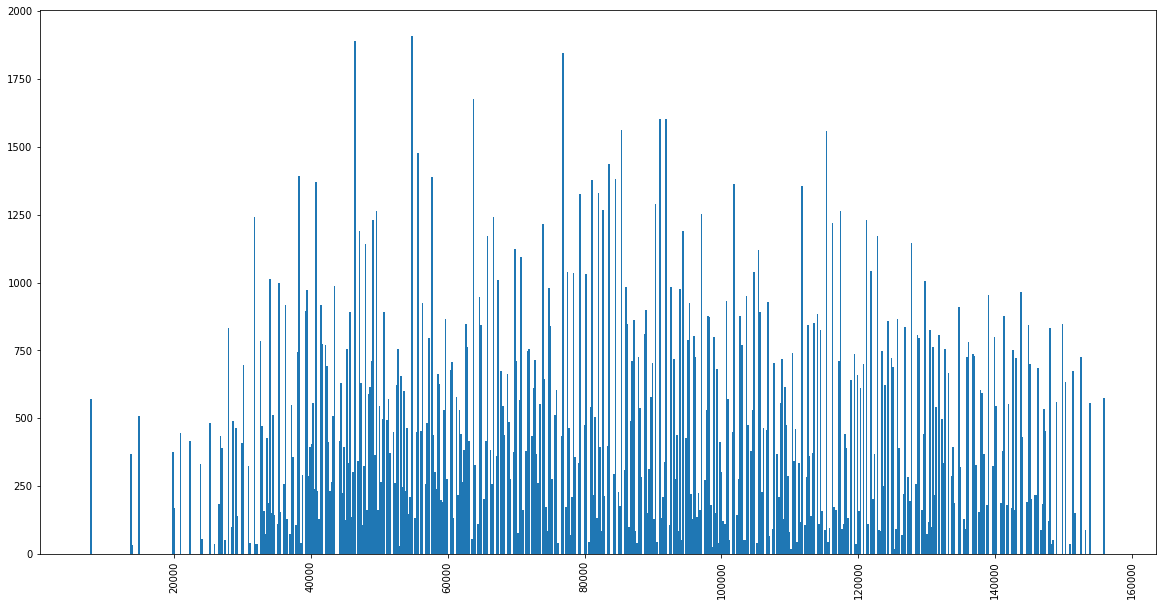

In [17]:
plt.figure(figsize=(20, 10))
plt.hist(trip_id_df['trip_id_comp_6_dig_id'], bins=658)
plt.xticks(rotation=90)
plt.show()

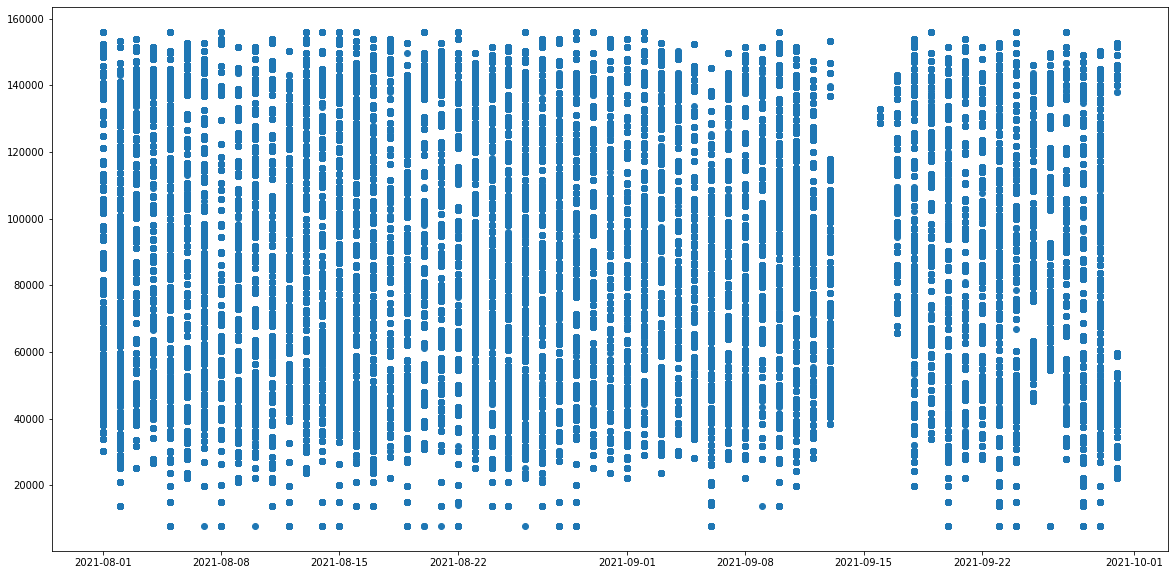

In [18]:
plt.figure(figsize=(20, 10))
plt.scatter(trip_id_df['timestamp'].dt.date, trip_id_df['trip_id_comp_6_dig_id'])
plt.show()

In [19]:
len(set(trip_id_df['trip_id_comp_3_dig_id']))

52

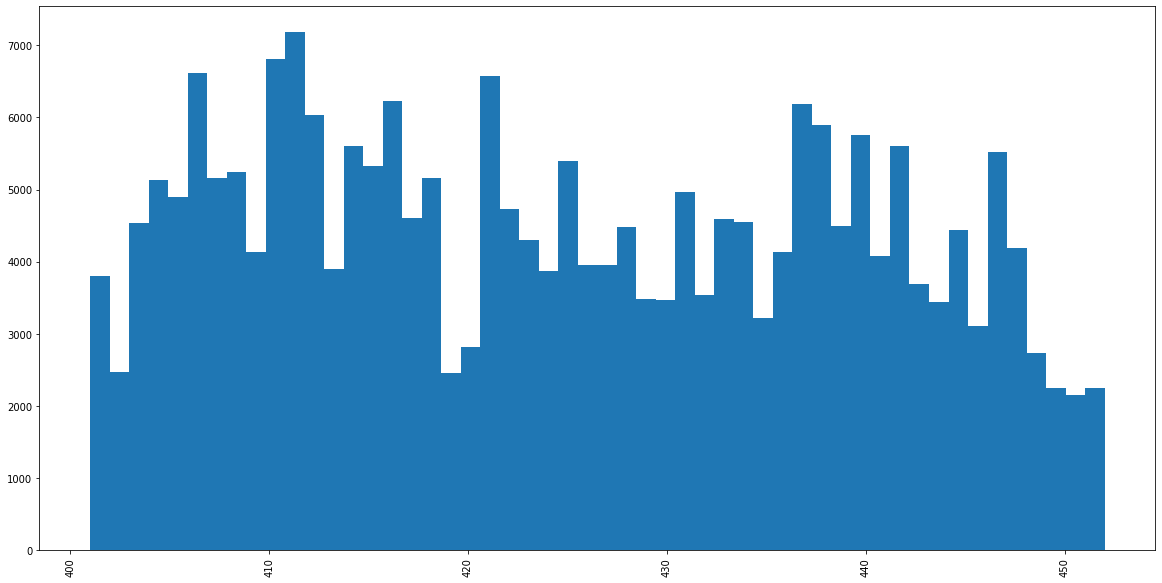

In [20]:
plt.figure(figsize=(20, 10))
plt.hist(trip_id_df['trip_id_comp_3_dig_id'], bins=52)
plt.xticks(rotation=90)
plt.show()

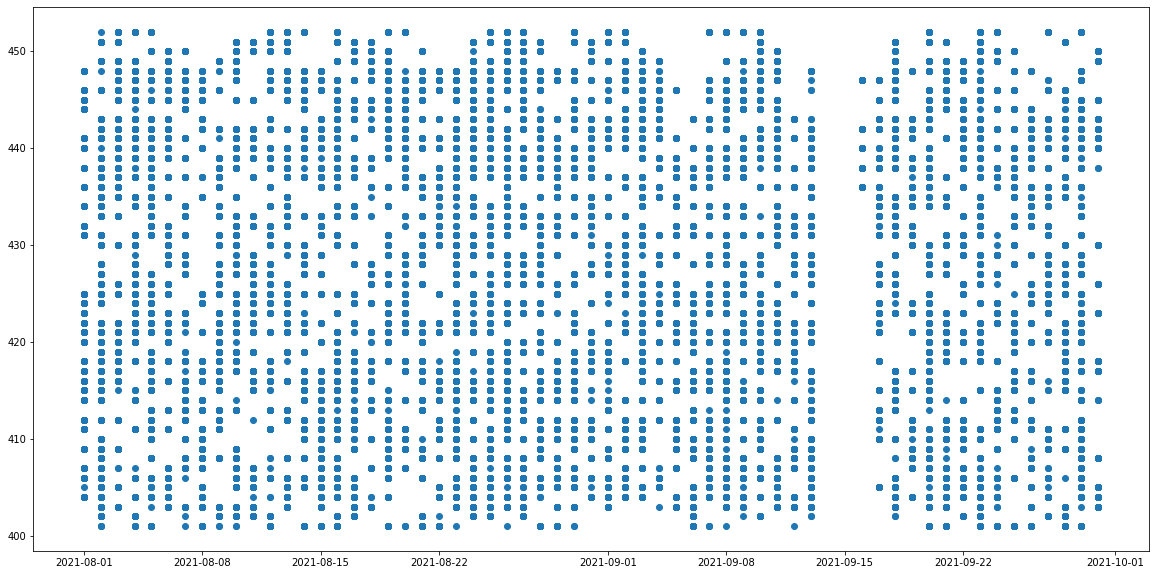

In [21]:
plt.figure(figsize=(20, 10))
plt.scatter(trip_id_df['timestamp'].dt.date, trip_id_df['trip_id_comp_3_dig_id'])
plt.show()

In [22]:
len(set(trip_id_df['trip_id_comp_9_dig_id']))

887

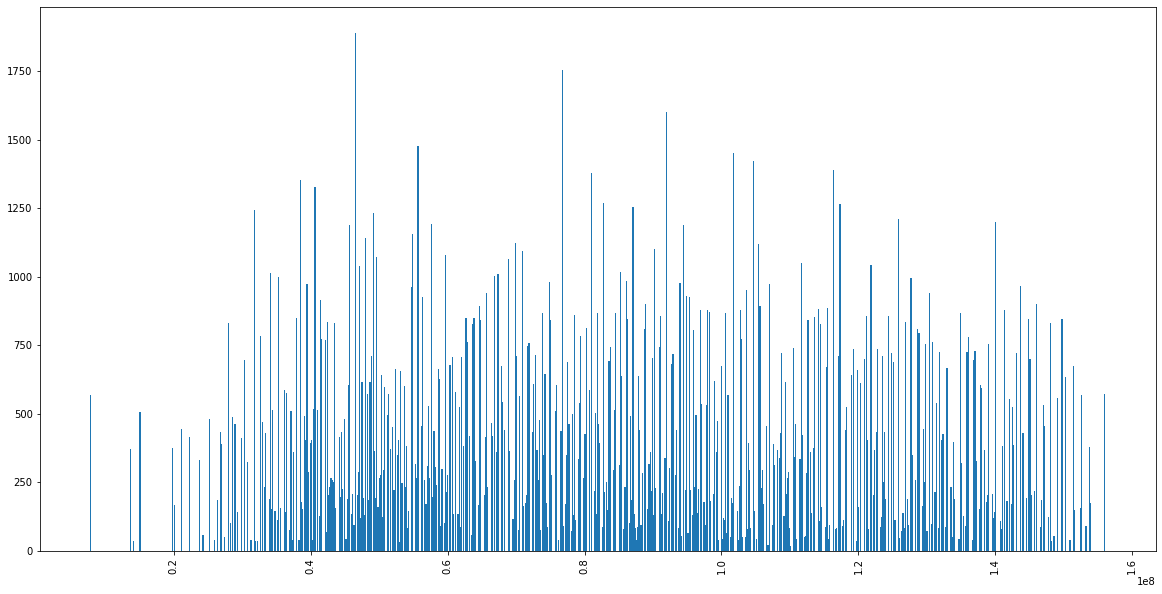

In [23]:
plt.figure(figsize=(20, 10))
plt.hist(trip_id_df['trip_id_comp_9_dig_id'], bins=887)
plt.xticks(rotation=90)
plt.show()

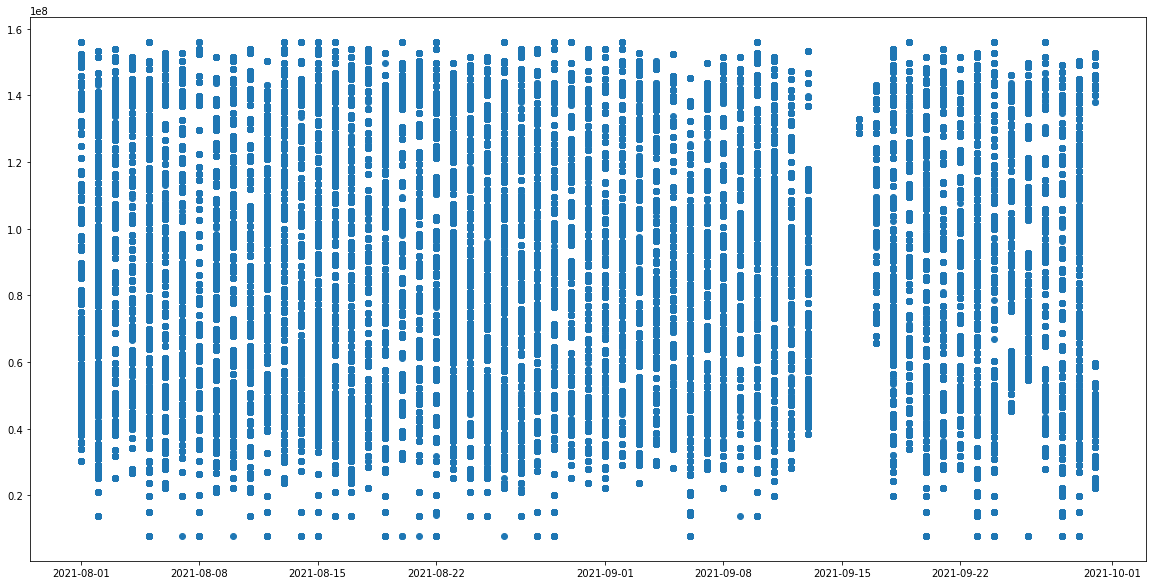

In [24]:
plt.figure(figsize=(20, 10))
plt.scatter(trip_id_df['timestamp'].dt.date, trip_id_df['trip_id_comp_9_dig_id'])
plt.show()

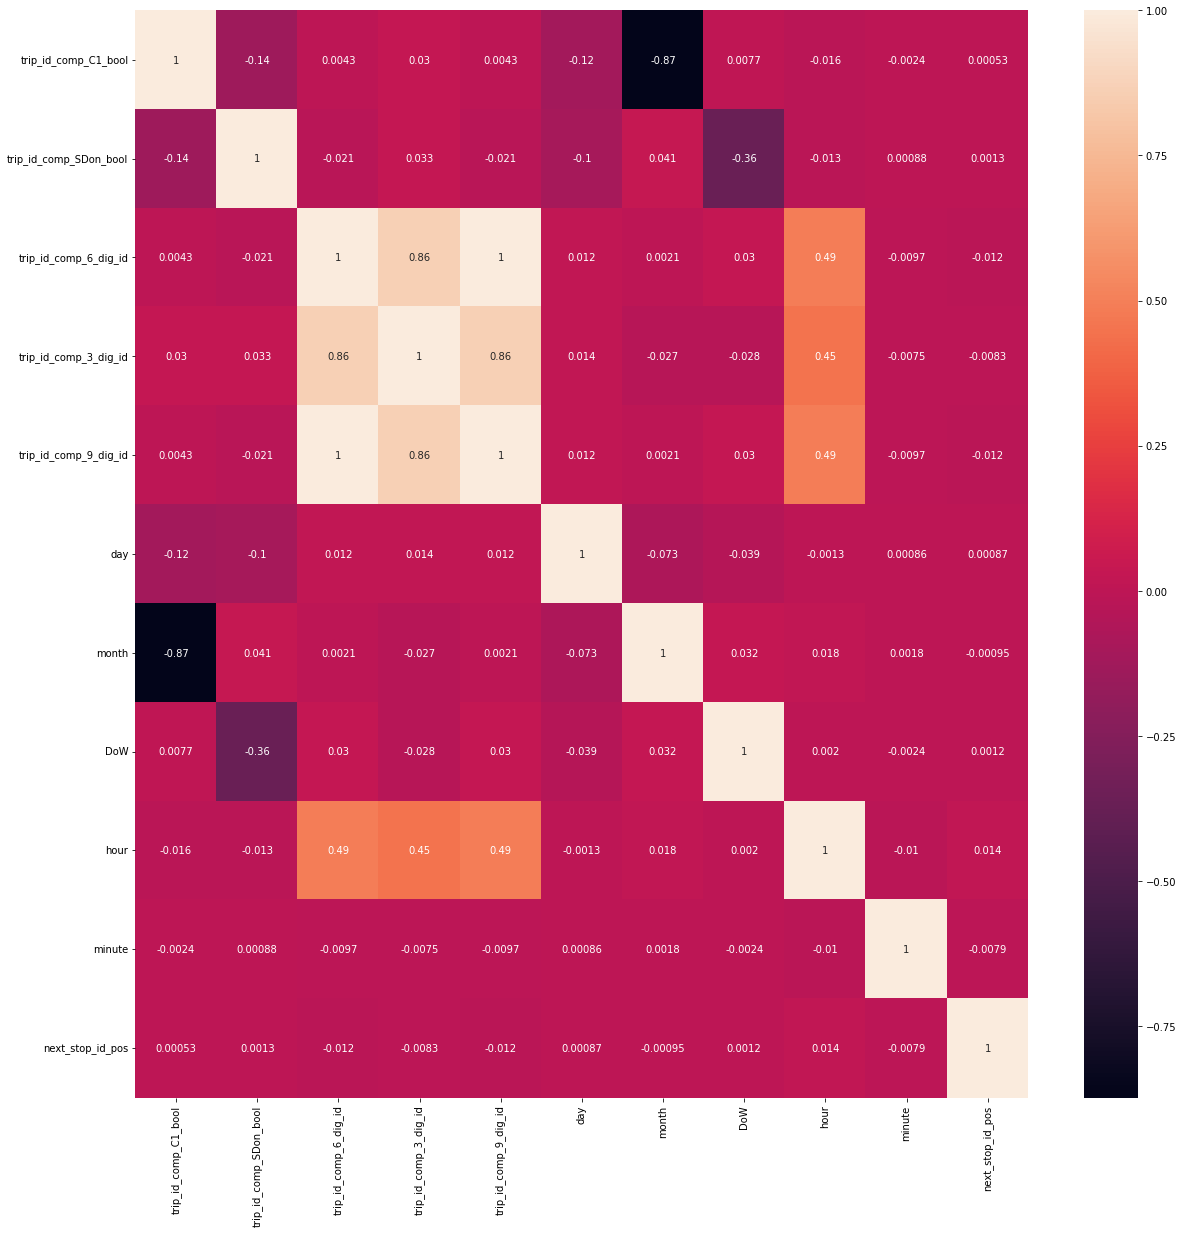

In [25]:
corr = trip_id_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2g")
plt.show()

In [59]:
# can we predict 6 digit component of trip_id from time and location features?
time_loc_features = ['day', 'month', 'DoW', 'hour', 'minute', 'next_stop_id_pos']
train, test = train_test_split(trip_id_df, test_size=0.1)
train_x = train[time_loc_features]
train_y = train['trip_id_comp_6_dig_id']
test_x = test[time_loc_features]
test_y = test['trip_id_comp_6_dig_id']

model = LassoCV().fit(train_x, train_y)
print('Linear Regression')
print('R^2:', model.score(test_x, test_y))
print('\n')
print('Feature Importance:')
model_coefs = model.coef_
importances = []
for (i, feature) in enumerate(time_loc_features):
  importance = (feature, model_coefs[i])
  importances.append(importance)
importances.sort(key=lambda x:np.abs(x[1]), reverse=True)
for (feature, importance) in importances:
  print(f'{feature}: {importance:.1f}')

print('\n')
print('-----------------------')
print('\n')

model = RandomForestRegressor(random_state=0)
model.fit(train_x, train_y)
print('Random Forest')
print('R^2:', model.score(test_x, test_y))
print('\n')
print('Feature Importance:')
model_coefs = model.feature_importances_
importances = []
for (i, feature) in enumerate(time_loc_features):
  importance = (feature, model_coefs[i])
  importances.append(importance)
importances.sort(key=lambda x:np.abs(x[1]), reverse=True)
for (feature, importance) in importances:
  print(f'{feature}: \t{importance:.1f}')

Linear Regression
R^2: 0.24675820818678063


Feature Importance:
hour: 2795.5
DoW: 477.2
month: -74.2
day: 52.8
next_stop_id_pos: -47.3
minute: -8.8


-----------------------


Random Forest
R^2: 0.9882670814979022


Feature Importance:
hour: 	0.9
minute: 	0.0
next_stop_id_pos: 	0.0
day: 	0.0
DoW: 	0.0
month: 	0.0


In [60]:
# can we predict 3 digit component of trip_id from time and location features?
train, test = train_test_split(trip_id_df, test_size=0.1)
train_x = train[time_loc_features]
train_y = train['trip_id_comp_3_dig_id']
test_x = test[time_loc_features]
test_y = test['trip_id_comp_3_dig_id']

model = LassoCV().fit(train_x, train_y)
print('Linear Regression')
print('R^2:', model.score(test_x, test_y))
print('\n')
print('Feature Importance:')
model_coefs = model.coef_
importances = []
for (i, feature) in enumerate(time_loc_features):
  importance = (feature, model_coefs[i])
  importances.append(importance)
importances.sort(key=lambda x:np.abs(x[1]), reverse=True)
for (feature, importance) in importances:
  print(f'{feature}: {importance:.1f}')

print('\n')
print('-----------------------')
print('\n')

model = RandomForestRegressor(random_state=0)
model.fit(train_x, train_y)
print('Random Forest')
print('R^2:', model.score(test_x, test_y))
print('\n')
print('Feature Importance:')
model_coefs = model.feature_importances_
importances = []
for (i, feature) in enumerate(time_loc_features):
  importance = (feature, model_coefs[i])
  importances.append(importance)
importances.sort(key=lambda x:np.abs(x[1]), reverse=True)
for (feature, importance) in importances:
  print(f'{feature}: \t{importance:.1f}')

Linear Regression
R^2: 0.19695769593068413


Feature Importance:
hour: 1.1
month: -0.8
DoW: -0.2
day: 0.0
next_stop_id_pos: -0.0
minute: -0.0


-----------------------


Random Forest
R^2: 0.8503496151374301


Feature Importance:
hour: 	0.7
minute: 	0.1
next_stop_id_pos: 	0.1
day: 	0.0
DoW: 	0.0
month: 	0.0


In [61]:
# can we predict 3 digit component of trip_id from time and location features?
train, test = train_test_split(trip_id_df, test_size=0.1)
train_x = train[time_loc_features]
train_y = train['trip_id_comp_9_dig_id']
test_x = test[time_loc_features]
test_y = test['trip_id_comp_9_dig_id']

model = LassoCV().fit(train_x, train_y)
print('Linear Regression')
print('R^2:', model.score(test_x, test_y))
print('\n')
print('Feature Importance:')
model_coefs = model.coef_
importances = []
for (i, feature) in enumerate(time_loc_features):
  importance = (feature, model_coefs[i])
  importances.append(importance)
importances.sort(key=lambda x:np.abs(x[1]), reverse=True)
for (feature, importance) in importances:
  print(f'{feature}: {importance:.1f}')

print('\n')
print('-----------------------')
print('\n')

model = RandomForestRegressor(random_state=0)
model.fit(train_x, train_y)
print('Random Forest')
print('R^2:', model.score(test_x, test_y))
print('\n')
print('Feature Importance:')
model_coefs = model.feature_importances_
importances = []
for (i, feature) in enumerate(time_loc_features):
  importance = (feature, model_coefs[i])
  importances.append(importance)
importances.sort(key=lambda x:np.abs(x[1]), reverse=True)
for (feature, importance) in importances:
  print(f'{feature}: \t{importance:.1f}')

Linear Regression
R^2: 0.24515171821579496


Feature Importance:
hour: 2794222.9
DoW: 457530.3
day: 50598.8
next_stop_id_pos: -47556.9
minute: -8597.3
month: -0.0


-----------------------


Random Forest
R^2: 0.9886319990965646


Feature Importance:
hour: 	0.9
minute: 	0.0
next_stop_id_pos: 	0.0
day: 	0.0
DoW: 	0.0
month: 	0.0


# Weather Features

In [29]:
num_weather_features_df = weather_df.copy()
num_weather_features_df = num_weather_features_df.drop(columns=['Date time', 'Conditions'])

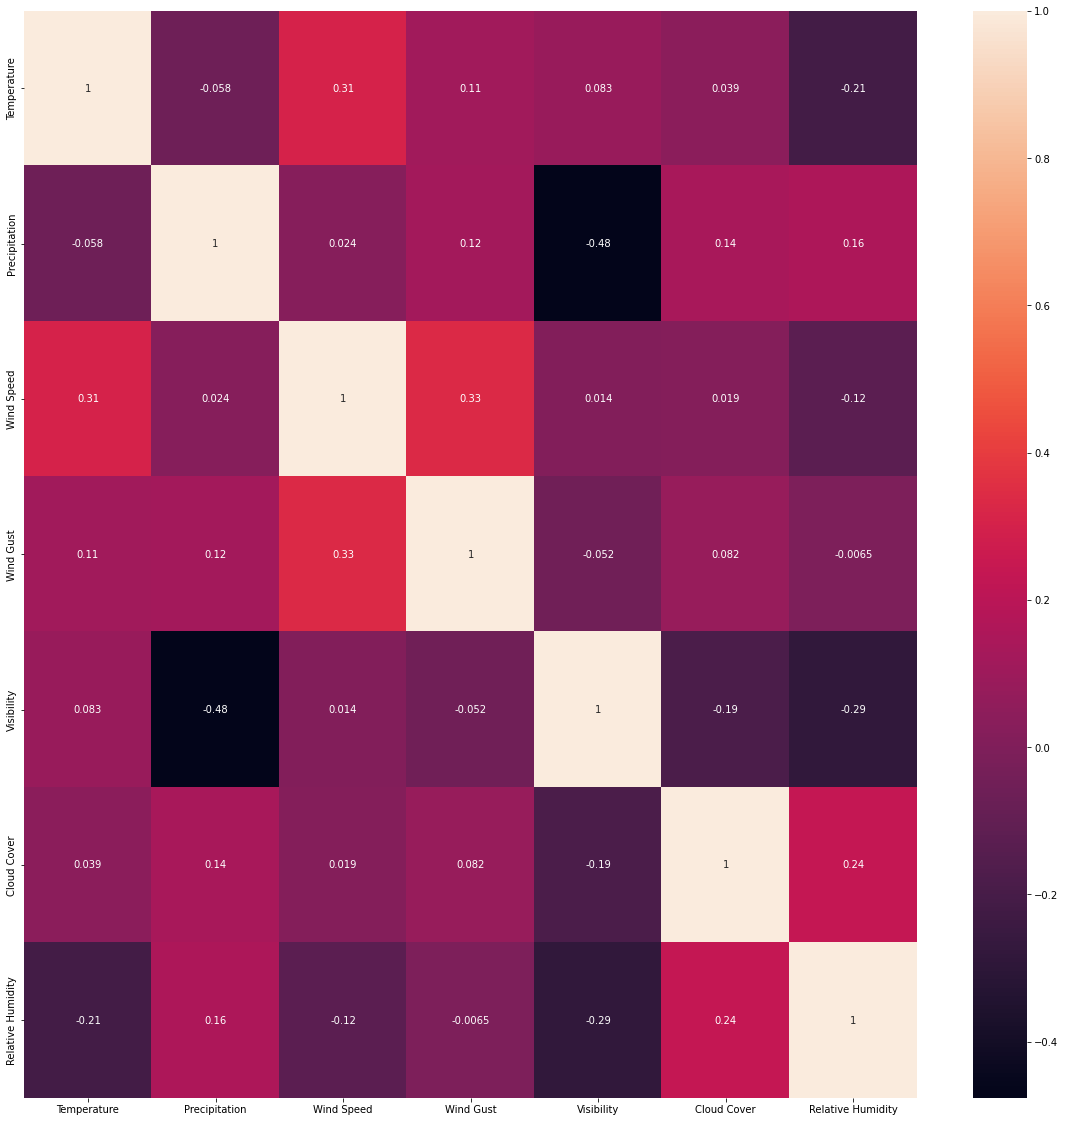

In [30]:
corr = num_weather_features_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2g")
plt.show()

## Examine `Temperature` and `Relative Humidity`

In [31]:
route_weather_df['Temperature'].describe()

count    233099.000000
mean         23.833237
std           3.514461
min          12.300000
25%          22.000000
50%          23.900000
75%          26.200000
max          33.400000
Name: Temperature, dtype: float64

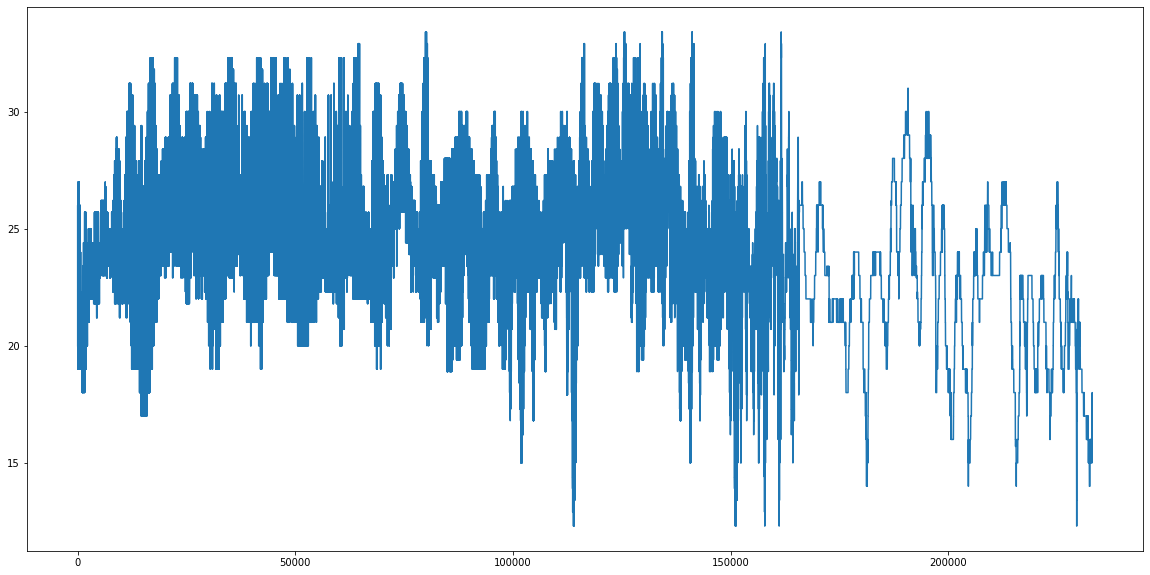

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(route_weather_df['Temperature'])
plt.show()

In [33]:
route_weather_df['Relative Humidity'].describe()

count    233099.000000
mean         71.250382
std          16.331161
min          30.790000
25%          58.190000
50%          73.280000
75%          83.560000
max         100.000000
Name: Relative Humidity, dtype: float64

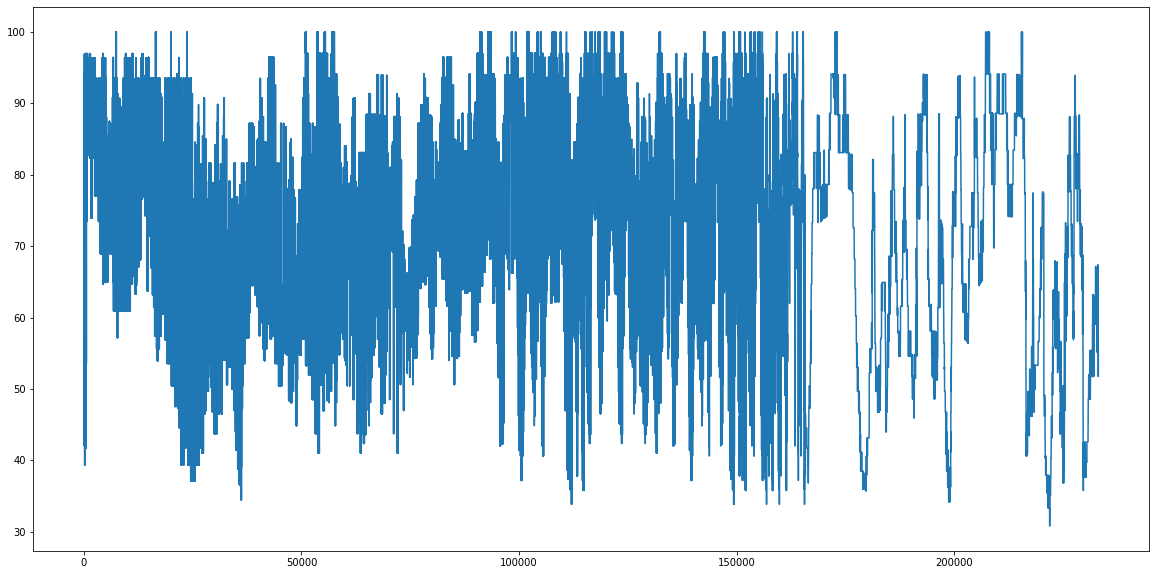

In [34]:
plt.figure(figsize=(20, 10))
plt.plot(route_weather_df['Relative Humidity'])
plt.show()

In [35]:
# compute heat index

def to_F(C):
  return (C * 9 / 5) + 32.0

def compute_HI(C, RH):
  #source: https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml

  T = to_F(C)

  HI = 0.5 * (T + 61.0 + ((T - 68.0) * 1.2) + (RH * 0.094))

  if HI < 80:
    return (T + HI) / 2

  else:
    HI = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - (0.00683783 * T * T) - (0.05481717 * RH * RH) + (0.00122874 * T * T * RH) + (0.00085282 * T * RH * RH) - (0.00000199 * T * T * RH * RH)

    if (RH < 0.13) and (80 <= T <= 112):
      adj = ((13.0 - RH) / 4.0) * np.sqrt((17.0 - np.abs(T - 95.0)) / 17.0)
      return HI - adj

    elif (RH > 0.85) and (80.0 <= T <= 87.0):
      adj = ((RH - 85.0) / 10.0) * ((87.0 - T) / 5.0)
      return HI + adj

    else:
      return HI

In [36]:
HI = route_weather_df.apply(lambda x: compute_HI(x['Temperature'], x['Relative Humidity']), axis=1)

In [37]:
HI.describe()

count    233099.000000
mean         75.710048
std           7.631443
min          53.255520
25%          71.276675
50%          74.874425
75%          79.070790
max         101.247031
dtype: float64

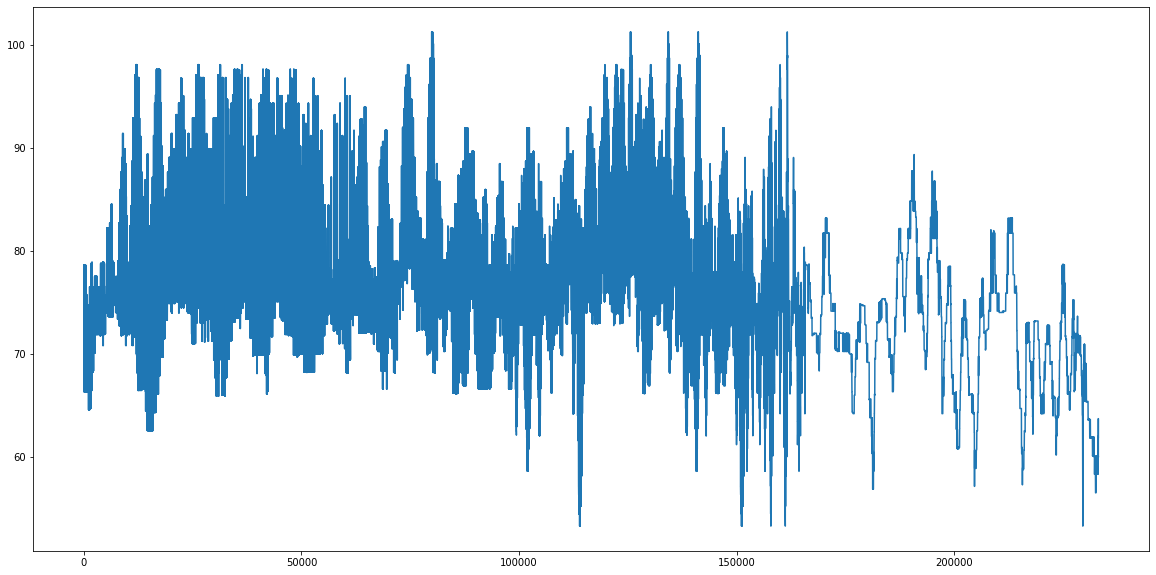

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(HI)
plt.show()

In [39]:
HI.corr(route_weather_df['Temperature'])

0.9708833967490826

In [40]:
HI.corr(route_weather_df['Relative Humidity'])

-0.158398933726972

In [41]:
# can we predict Temperature from HI?
model = LassoCV().fit(np.array(HI).reshape(-1, 1), route_weather_df['Temperature'])
model.score(np.array(HI).reshape(-1, 1), route_weather_df['Temperature'])

0.942594262067744

In [42]:
# can we predict Relative Humidity from HI?
model = LassoCV().fit(np.array(HI).reshape(-1, 1), route_weather_df['Relative Humidity'])
model.score(np.array(HI).reshape(-1, 1), route_weather_df['Relative Humidity'])

0.023751232510274112

## Examine `Wind Speed` and `Wind Gust`

In [43]:
route_weather_df['Wind Speed'].describe()

count    233099.000000
mean         16.738334
std           7.898982
min           0.000000
25%          11.200000
50%          16.600000
75%          22.300000
max          46.400000
Name: Wind Speed, dtype: float64

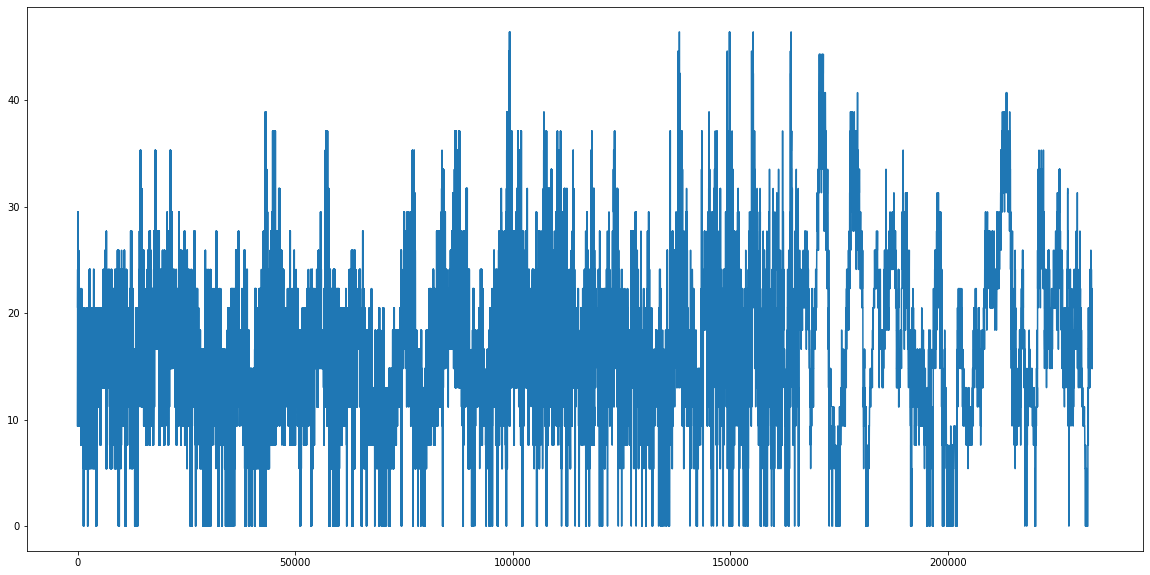

In [44]:
plt.figure(figsize=(20, 10))
plt.plot(route_weather_df['Wind Speed'])
plt.show()

In [45]:
route_weather_df['Wind Gust'].describe()

count    233099.000000
mean          2.516455
std           9.897616
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          61.200000
Name: Wind Gust, dtype: float64

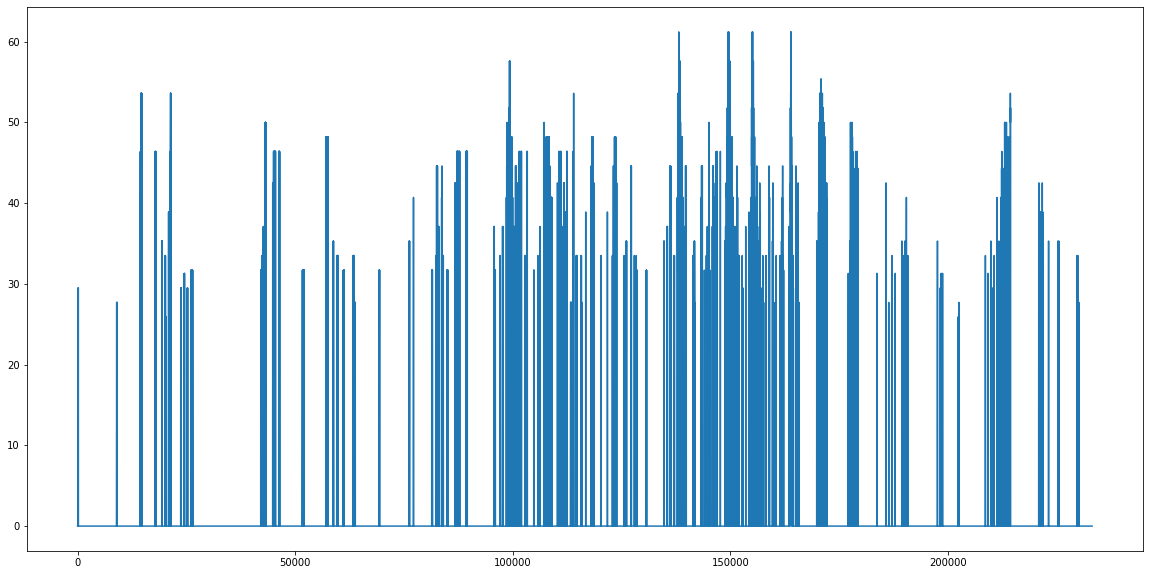

In [46]:
plt.figure(figsize=(20, 10))
plt.plot(route_weather_df['Wind Gust'])
plt.show()

In [47]:
# number of obserations where Wind Speed == 0 and wind Gust > 0
route_weather_df[(route_weather_df['Wind Speed'] == 0) & (route_weather_df['Wind Gust'] > 0)].shape[0]

0

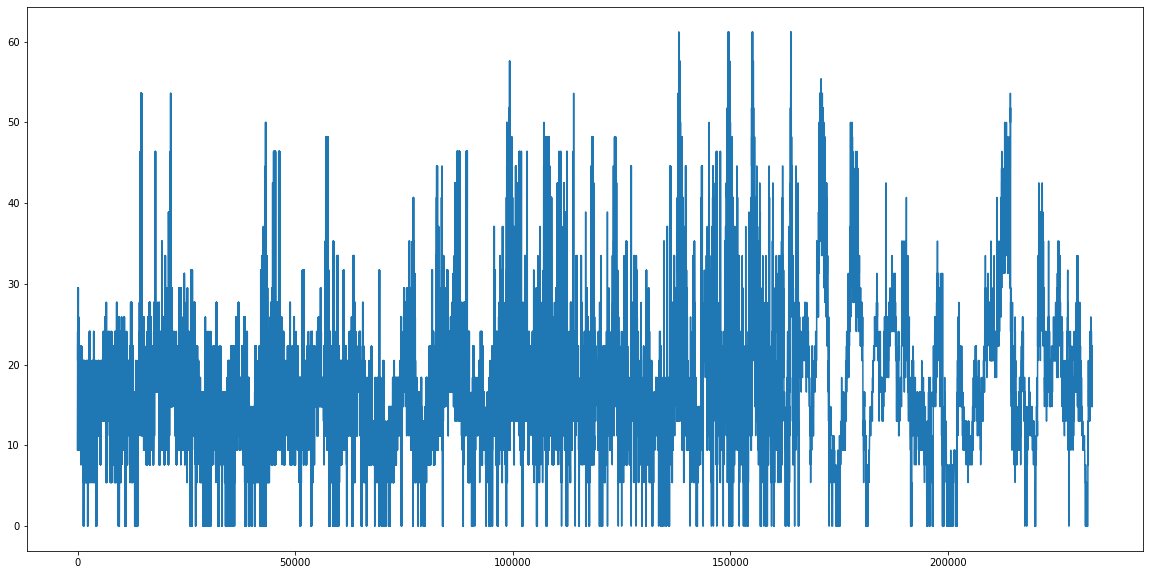

In [48]:
plt.figure(figsize=(20, 10))
plt.plot(route_weather_df[['Wind Speed', 'Wind Gust']].max(axis=1))
plt.show()

In [49]:
# can we predict Wind Speed from Max Wind Speed?
model = LassoCV().fit(np.array(route_weather_df[['Wind Speed', 'Wind Gust']].max(axis=1)).reshape(-1, 1), route_weather_df['Wind Speed'])
model.score(np.array(route_weather_df[['Wind Speed', 'Wind Gust']].max(axis=1)).reshape(-1, 1), route_weather_df['Wind Speed'])

0.9071053799605715

In [50]:
# can we predict Wind Gust from Max Wind Speed?
model = LassoCV().fit(np.array(route_weather_df[['Wind Speed', 'Wind Gust']].max(axis=1)).reshape(-1, 1), route_weather_df['Wind Gust'])
model.score(np.array(route_weather_df[['Wind Speed', 'Wind Gust']].max(axis=1)).reshape(-1, 1), route_weather_df['Wind Gust'])

0.4221627922008795

## Examine `Visibility`

In [51]:
route_weather_df['Visibility'].describe()

count    233099.000000
mean         15.546575
std           2.046574
min           1.000000
25%          16.000000
50%          16.000000
75%          16.000000
max          16.000000
Name: Visibility, dtype: float64

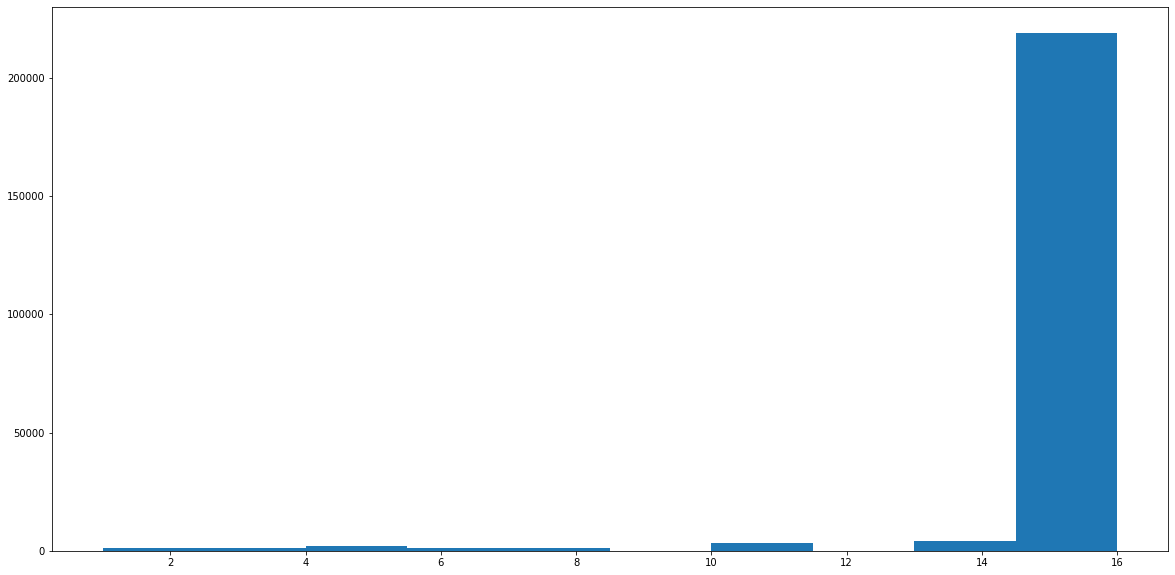

In [52]:
plt.figure(figsize=(20, 10))
plt.hist(route_weather_df['Visibility'])
plt.show()

In [53]:
# can we predict Visibiliry from Precipitation, Cloud Cover, and Relative Humidity?
model = LassoCV().fit(route_weather_df[['Precipitation', 'Cloud Cover', 'Relative Humidity']], route_weather_df['Visibility'])
model.score(route_weather_df[['Precipitation', 'Cloud Cover', 'Relative Humidity']], route_weather_df['Visibility'])

0.3593677141005387

In [54]:
route_weather_df['Visibility'].corr(route_weather_df['passenger_count'])

0.06391068352721639

## Examine `Conditions`

In [55]:
set(route_weather_df['Conditions'])

{'Clear',
 'Overcast',
 'Partially cloudy',
 'Rain',
 'Rain, Overcast',
 'Rain, Partially cloudy'}

In [56]:
set(route_weather_df['Cloud Cover'])

{0.0, 25.0, 50.0, 88.0, 100.0}

Rain


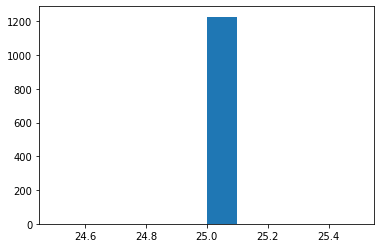

Rain, Partially cloudy


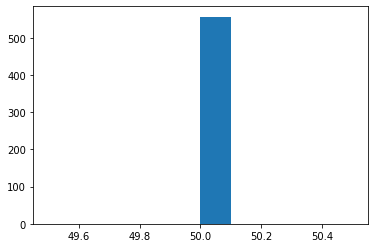

Partially cloudy


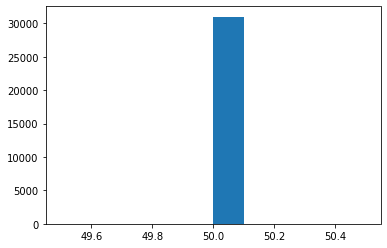

Overcast


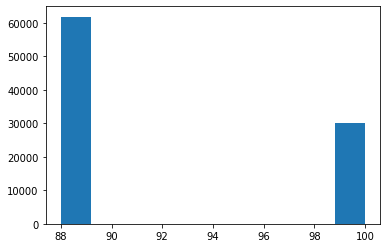

Clear


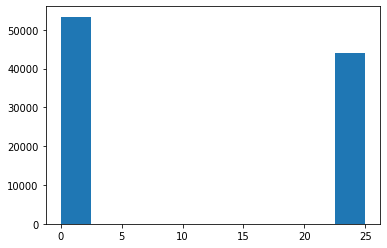

Rain, Overcast


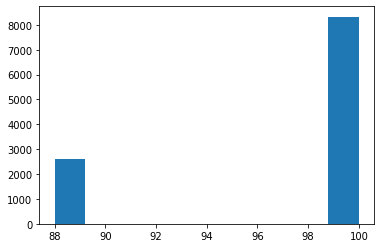

In [57]:
for condition in set(route_weather_df['Conditions']):
  print(condition)
  plt.hist(route_weather_df[route_weather_df['Conditions'] == condition]['Cloud Cover'])
  plt.show()

# Feature Extraction

In [58]:
route_weather_df.head()

,route,direction,trip_id,service_date,vehicle_id,timestamp,lat,lon,bearing,prior_stop_id,next_stop_id,next_stop_id_pos,next_stop_d_along_route,next_stop_est_sec,passenger_count,Temperature,Precipitation,Wind Speed,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions,trip_id_components
0,B46,1,MTA NYCT_FB_C1-Saturday-138700_B46_446,2021-07-31,MTA NYCT_7640,2021-08-01 00:00:56,40.646607,-73.929840,275.83255,MTA_308777,MTA_303690,35,8394.73,27.0,24.0,20.0,0.0,9.4,0.0,16.0,0.0,77.76,Clear,"[MTA NYCT, FB, C1-Saturday-138700, B46, 446]"
1,B46,1,MTA NYCT_FB_C1-Sunday-116400_B46_440,2021-08-08,MTA NYCT_7622,2021-08-08 20:05:17,40.668274,-73.931170,264.13710,MTA_307373,MTA_307026,24,5951.03,16.0,15.0,19.0,0.0,22.3,0.0,11.0,25.0,93.93,Clear,"[MTA NYCT, FB, C1-Sunday-116400, B46, 440]"
2,B46,1,MTA NYCT_FB_C1-Sunday-118400_B46_442,2021-08-08,MTA NYCT_7322,2021-08-08 20:07:54,40.691222,-73.930729,281.72510,MTA_303664,MTA_303665,14,3389.59,32.0,5.0,19.0,0.0,24.1,0.0,16.0,25.0,93.93,Clear,"[MTA NYCT, FB, C1-Sunday-118400, B46, 442]"
3,B46,1,MTA NYCT_FB_C1-Sunday-116400_B46_440,2021-08-08,MTA NYCT_7622,2021-08-08 20:15:58,40.649895,-73.930187,276.29813,MTA_308800,MTA_303688,33,7974.97,30.0,11.0,19.0,0.0,20.5,0.0,16.0,50.0,93.93,Partially cloudy,"[MTA NYCT, FB, C1-Sunday-116400, B46, 440]"
4,B46,1,MTA NYCT_FB_C1-Weekday-SDon-078600_B46_420,2021-08-02,MTA NYCT_7307,2021-08-02 14:22:49,40.626628,-73.927702,275.86197,MTA_303698,MTA_303699,44,10592.78,29.0,16.0,26.0,0.0,20.5,0.0,16.0,25.0,44.54,Clear,"[MTA NYCT, FB, C1-Weekday-SDon-078600, B46, 420]"


In [62]:
route_weather_df_4_ml = route_weather_df.copy()

# extract relevant datetime data
route_weather_df_4_ml['day'] = route_weather_df_4_ml['timestamp'].dt.day
route_weather_df_4_ml['month'] = route_weather_df_4_ml['timestamp'].dt.month
route_weather_df_4_ml['year'] = route_weather_df_4_ml['timestamp'].dt.year
route_weather_df_4_ml['DoW'] = route_weather_df_4_ml['timestamp'].dt.dayofweek
route_weather_df_4_ml['hour'] = route_weather_df_4_ml['timestamp'].dt.hour
route_weather_df_4_ml['minute'] = route_weather_df_4_ml['timestamp'].dt.minute

# extract relevant trip_id data
route_weather_df_4_ml['trip_id_comp_SDon_bool'] = [1 if trip_id_components[2].split('-')[-2] == 'SDon' else 0 for trip_id_components in list(route_weather_df_4_ml['trip_id_components'])]
route_weather_df_4_ml['trip_id_comp_6_dig_id'] = [trip_id_components[2].split('-')[-1] for trip_id_components in list(route_weather_df['trip_id_components'])]
route_weather_df_4_ml['trip_id_comp_3_dig_id'] = [trip_id_components[-1] for trip_id_components in list(route_weather_df_4_ml['trip_id_components'])]

# extract relevant vehicle_id data
route_weather_df_4_ml['vehicle_id'] = [vehicle_id.split('_')[1] for vehicle_id in list(route_weather_df_4_ml['vehicle_id'])]

# compute heat index from Temperature and Humidity
route_weather_df_4_ml['Heat Index'] = route_weather_df_4_ml.apply(lambda x: compute_HI(x['Temperature'], x['Relative Humidity']), axis=1)

# compute Max Wind Speed from Wind Speed and Wind Gust
route_weather_df_4_ml['Max Wind Speed'] = route_weather_df[['Wind Speed', 'Wind Gust']].max(axis=1)

# drop redundant / irrelevant columns 
# note: next_stop_d_along_route dropped because perfectly correlated w/ next_stop_id_pos (i.e. represents cumulative distance along route to each stop)
# note: Conditions dropped in favor of downstream feature engineering (e.g. using Precipitation and Cloud Cover)
# note: Visibility dropped becasue of (1) low correlation with passenger_count and (2) moderate correlation with Precipitation, Cloud Cover, and Relative Humidity
route_weather_df_4_ml = route_weather_df_4_ml.drop(columns=['route', 'trip_id', 'timestamp', 'service_date', 'prior_stop_id', 'next_stop_d_along_route', 'Temperature', 'Wind Speed', 'Wind Gust', 'Visibility', 'Conditions', 'trip_id_components'])

# Partition Data by `direction`

In [64]:
route_weather_df_4_ml_0 = route_weather_df_4_ml[route_weather_df_4_ml['direction'] == 0].copy()
route_weather_df_4_ml_1 = route_weather_df_4_ml[route_weather_df_4_ml['direction'] == 1].copy()

route_weather_df_4_ml_0 = route_weather_df_4_ml_0.drop(columns='direction')
route_weather_df_4_ml_1 = route_weather_df_4_ml_1.drop(columns='direction')

# drop lat, lon, bearing, and next_stop_id columns since (1) location and segment data encoded in next_stop_id_pos and (2) direction encoded in corresponding data partition
route_weather_df_4_ml_0 = route_weather_df_4_ml_0.drop(columns=['lat', 'lon', 'bearing', 'next_stop_id'])
route_weather_df_4_ml_1 = route_weather_df_4_ml_1.drop(columns=['lat', 'lon', 'bearing', 'next_stop_id'])

In [66]:
print(route_weather_df_4_ml.shape[0])
print(route_weather_df_4_ml_0.shape[0])
print(route_weather_df_4_ml_1.shape[0])

233099
115706
117393


# Save

In [67]:
route_weather_df_4_ml_0.to_csv(f'/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Combined/bus_{route_str}_0_weather_{station_str}.csv', index=False)
route_weather_df_4_ml_1.to_csv(f'/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Combined/bus_{route_str}_1_weather_{station_str}.csv', index=False)